## Imports

In [1]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob
# import seaborn as sns; sns.set()
import pickle
%matplotlib nbagg

### Import an existing vectors dictionary

In [2]:
def write_vectors(vectors):
    with open('vectors.p', 'wb') as fp:
        pickle.dump(vectors, fp, protocol=pickle.HIGHEST_PROTOCOL) 
        
def read_vectors():
    with open('vectors.p', 'rb') as fp:
        vectors = pickle.load(fp)
    return vectors
vectors = read_vectors()

## Processing

### Calibrate Camera

In [ ]:
# Variables
calibration_dir = "calibration_100"
factor = 0.2
expected_num_markers = 24

In [ ]:
# Processing
processed_dir = preprocess_photos(calibration_dir, factor, expected_num_markers)
calibrate(processed_dir, factor=factor, vectors=vectors)

### Draw Gridboards

In [165]:
# Variables
original_dir = "recog/gridboards_2/100"
factor = 0.2
expected_num_markers = 8

nx = 2
ny = 2
num_gridboards = 2
marker_size = 0.025 # 25mm
between_markers = 0.005
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
save_dir = ""
gridboards = make_gridboards(nx, ny, marker_size, between_markers, 
                aruco_dict, num_gridboards, save_dir)
# print(vectors)
# processed_dir = None

recog/gridboards_2/100_20/IMG_20191202_184648.jpg


(array([[-2.80145145],
        [-0.08032665],
        [ 1.27867343]]), array([[0.06848218],
        [0.01933793],
        [0.40304576]]))

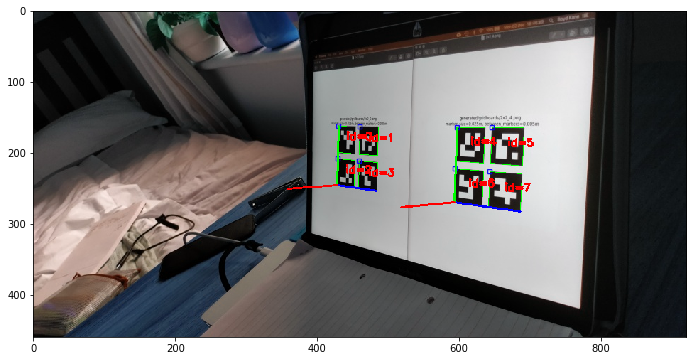

In [170]:
# Processing
if not processed_dir:
    processed_dir = preprocess_photos(original_dir, factor, expected_num_markers)
image_paths = sorted(glob.glob(os.path.join(processed_dir, "*")))
image_path = image_paths[15]
rvecs, tvecs = plot_gridboard_axes(image_path, vectors, factor, gridboards)

### Draw individual markers

In [184]:
# Variables
marker_size = 0.023 # 23mm
length_of_axis = marker_size / 2
image_paths = sorted(glob.glob("recog/gridboards_2/100_20/*"))
image_path = image_paths[9]
factor = 0.2
dist_coeffs = vectors[str(factor)]['dist_coeffs']
cam_matrix = vectors[str(factor)]['cam_matrix']

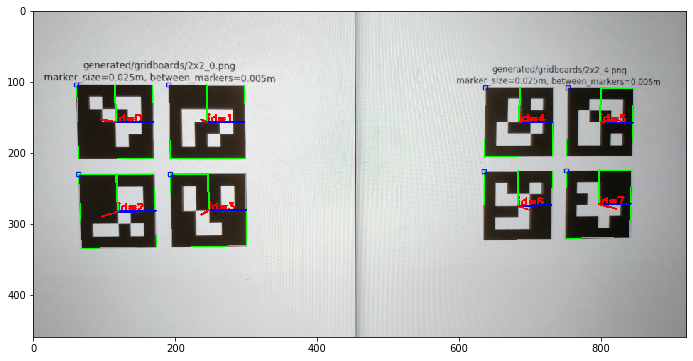

In [185]:
# Processing
rvecs, tvecs = plot_marker_axes(image_path, vectors, factor)

In [ ]:
# TODO Calculate the matrix from one marker to the other
"""
The returned transformation is the one that transforms points from 
the marker coordinate system to the camera coordinate system. 

marker coords: centered at (0, 0)

The marker coordinate system is centered on the middle of the marker, 
with the Z axis perpendicular to the marker plane. The coordinates of 
the four corners of the marker in its own coordinate system are: 
    (-markerLength/2, markerLength/2, 0), 
    (markerLength/2, markerLength/2, 0), 
    (markerLength/2, -markerLength/2, 0), 
    (-markerLength/2, -markerLength/2, 0)

"""
marker_from = (rvecs[0], tvecs[0])
marker_to = (rvecs[1], tvecs[1])

# go from (0, 0, 0) in marker_from to (x, y, z) in marker_to
b



### Method Definitions

In [135]:
def remove_unclear(aruco_dict, image_paths, expected_num_markers):
    num_removed = 0
    if input(f"expected_num_markers={expected_num_markers}, [c]hange or proceed?: ") == "c":
        expected_num_markers = int(input("Enter new expected_num_markers: "))
    for i, file_path in enumerate(image_paths):
        frame = cv2.imread(file_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)
        if len(corners) != expected_num_markers:
            print(f"{file_path.split(os.sep)[-1]}: len(corners)={len(corners)}", end="")
            os.remove(file_path)
            print(f"\tremoving {file_path}:")
            num_removed += 1
    print(f"Removed {num_removed}, {len(image_paths)-num_removed} remaining")

In [136]:
def downsize(from_dir, to_dir, factor):
    image_paths = sorted(glob.glob(os.path.join(from_dir, "*")))
    if len(image_paths) == 0:
        if input(f"len(image_paths) == 0, change from_dir? [y]/n: ") == "y":
            from_dir = input("Enter new from_dir: ")
            image_paths = sorted(glob.glob(os.path.join(from_dir, "*")))
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        width = int(img.shape[1] * factor)
        height = int(img.shape[0] * factor)

        dim = (width, height)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        path = os.path.join(to_dir, image_path.split(os.sep)[-1])
        if not os.path.exists(to_dir):
            os.makedirs(to_dir)
        cv2.imwrite(os.path.join(to_dir, image_path.split(os.sep)[-1]), resized)
    print(f"Resized@{factor}, saved {len(image_paths)} files to {to_dir}")

In [137]:
def preprocess_photos(original_dir, factor, expected_num_markers):
#     original_dir = "recog/gridboards_1/100"
    # First downsize the original photos
    image_dir = f"{original_dir}_{int(factor*100)}"
    downsize(original_dir, image_dir, factor)
    
    # Remove all photos whose markers can't be seen
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*")))
    remove_unclear(aruco_dict, image_paths, expected_num_markers)
    return image_dir

In [146]:
def calibrate(image_dir, factor, vectors=None):
    print("Starting calibration()")
    if not vectors:
        vectors={}
    # Find the charuco_board in each image
    num_x, num_y = 7, 7
    ratio_marker_border = 6/8
    charuco_board = aruco.CharucoBoard_create(num_x, num_y, 1, ratio_marker_border, aruco_dict)
    allCorners = []
    allIds = []
    decimator = 0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*")))
    imsize = cv2.imread(image_paths[0]).shape[:2]
    print(f"Finding Charuco Corners in {len(image_paths)} files")
    for im in image_paths:
        print(".", end="")
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        if len(corners) > 0:
            # Sub-pixel detection
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, charuco_board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])
        decimator += 1
        
    # Finally, calibrate the camera using the found corners
    print("\nFinding camera matrices")
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    (ret, cam_matrix, dist_coeffs, rvecs, tvecs,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors
    ) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners, charucoIds=allIds,
                      board=charuco_board, imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,  distCoeffs=distCoeffsInit,  flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    scaled_errors = [error[0] / imsize[0] for error in perViewErrors]
    vectors[str(factor)] = {}
    vectors[str(factor)]["cam_matrix"] = cam_matrix
    vectors[str(factor)]["dist_coeffs"] = dist_coeffs
    vectors[str(factor)]["ret"] = ret   
    print("Done")

In [171]:
def plot_gridboard_axes(image_path, vectors, factor, gridboards=None):
    """
    Used to plot multiple gridboards, with one large set of axes per gridboard
    
    """
    dist_coeffs = vectors[str(factor)]['dist_coeffs']
    cam_matrix = vectors[str(factor)]['cam_matrix']
    nx = 2
    ny = 2
    marker_size = 0.025 # 25mm
    between_markers = 0.005 # 5mm
    markers_per_board = nx * ny
    length_of_axis = (marker_size + between_markers) * nx - between_markers
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
    offset = 0
    if not gridboards:
        gridboards = [aruco.GridBoard_create(
            nx, ny, marker_size, between_markers, aruco_dict, firstMarker=offset
        )]
    print(image_path)
    frame = cv2.imread(image_path)        
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)
    
    all_rvecs = []
    all_tvecs = []
    frame_with_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

#     print(f"ids={ids}")    
    for i, board in enumerate(gridboards):
        # Go through all the corners / ids found in the image, and just select the
        # ones relevant to the current board
        ids_subset = ids.copy()
        corners_subset = corners.copy()
        for j, item in enumerate(ids):
            if item[0] not in [val[0] for val in board.ids]:
                np.delete(ids_subset, j)
                np.delete(corners_subset, j)
        # Reset the vectors
        rvec = np.ones(shape=(3,1), dtype=float)
        tvec = np.ones(shape=(3,1), dtype=float)
        # Estimate the Board's pose
        ret, rvec, tvec = aruco.estimatePoseBoard(
                corners_subset, 
                ids_subset, 
                board, 
                cam_matrix,
                dist_coeffs, 
                rvec, 
                tvec
        )
        
        if ret == 0: # if no gridboard was found
            print("Failed to get BoardPose")
            rvecs, tvecs, objPoints = aruco.estimatePoseSingleMarkers(
                                                    corners, 
                                                    marker_size, 
                                                    cam_matrix, 
                                                    dist_coeffs)
            for i in range(len(tvecs)):
                frame_with_markers = cv2.drawFrameAxes(
                                        frame_with_markers, cam_matrix, 
                                        dist_coeffs, rvecs[i], tvecs[i], 
                                        length_of_axis, thickness=2)
                
        else:
            frame_with_markers = cv2.drawFrameAxes(frame_with_markers, cam_matrix, 
                                                   dist_coeffs, rvec, tvec, 
                                                   length_of_axis, thickness=2)
            all_rvecs.append(rvec)
            all_tvecs.append(tvec)
    plt.figure(figsize=(12,6))
    plt.imshow(frame_with_markers, interpolation = "nearest")
    return all_rvecs, all_tvecs



In [148]:
def plot_marker_axes(image_path, vectors, factor):
    """
    Used to plot multiple individual markers
    """
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
    dist_coeffs = vectors[str(factor)]['dist_coeffs']
    cam_matrix = vectors[str(factor)]['cam_matrix']
    marker_size = 0.025 # 25mm
    between_markers = 0.005 # 5mm
    length_of_axis = marker_size / 2

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)
    frame_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)
    rvecs, tvecs, objPoints = aruco.estimatePoseSingleMarkers(
                                corners, 
                                marker_size, 
                                cam_matrix, 
                                dist_coeffs)
    for i in range(len(tvecs)):
        frame_markers = cv2.drawFrameAxes(
            frame_markers, cam_matrix, 
            dist_coeffs, rvecs[i], tvecs[i], 
            length_of_axis, thickness=2)
    plt.figure(figsize=(12,6))
    plt.imshow(frame_markers, interpolation = "nearest")
    return rvecs, tvecs

## Data Visualisation

### Graph the rvecs, tvecs

In [110]:
# Variables
print(rvecs)
print(tvecs)

[[[ 3.10595502 -0.03870583  0.65899114]]

 [[ 3.10596812 -0.06749725  0.73855223]]

 [[ 3.08661536 -0.06589706  0.71094184]]

 [[ 3.04621009 -0.04839228  0.61452632]]]
[[[-0.03163153 -0.01872019  0.41063349]]

 [[-0.05919624 -0.01718078  0.39551425]]

 [[-0.03200617 -0.04879409  0.40667606]]

 [[-0.06050132 -0.04793513  0.39664666]]]


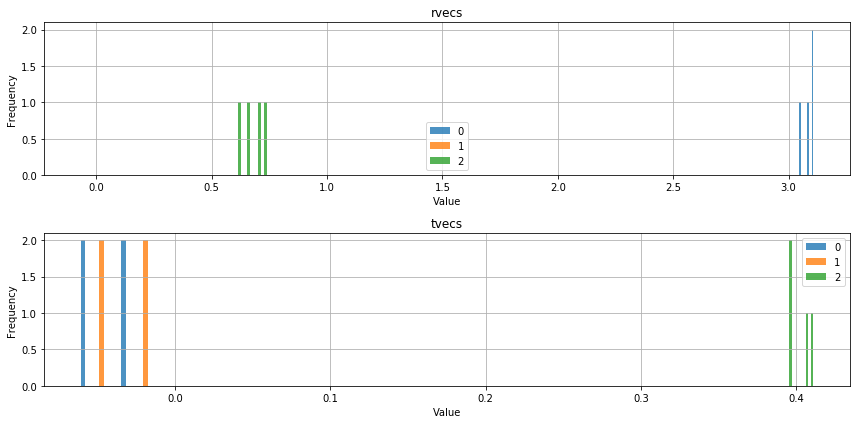

In [107]:
# Processing
fig, axes = plt.subplots(2, figsize=(12, 6))
for ax_i, vecs in enumerate([rvecs, tvecs]):
    for dim_i in range(3):
        axes[ax_i].hist([item[0][dim_i] for item in vecs], alpha=0.8, label=str(dim_i))
    axes[0].set_title("rvecs")
    axes[1].set_title("tvecs")
    axes[ax_i].set_xlabel("Value")
    axes[ax_i].set_ylabel("Frequency")
    axes[ax_i].legend()
    axes[ax_i].grid(True)
plt.tight_layout()
plt.show()

### Graph the Camera Matrix, Distortion Coefficients and Ret value

In [108]:
# Variables
factor = 0.2
dist_coeffs = vectors[str(factor)]['dist_coeffs']
cam_matrix = vectors[str(factor)]['cam_matrix']
ret = vectors[str(factor)]['ret']

Camera Matrix
[[760.02   0.   462.52]
 [  0.   760.02 233.02]
 [  0.     0.     1.  ]]


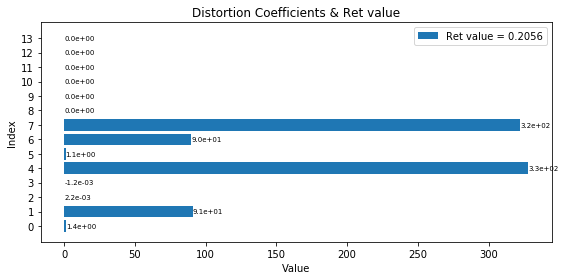

In [109]:
# Processing
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(range(len(dist_coeffs)), [val[0] for val in dist_coeffs], label=f"Ret value = {round(ret, 4)}")
ax.set_ylabel("Index")
ax.set_xlabel("Value")
ax.set_yticks(range(len(dist_coeffs)))
ax.set_title("Distortion Coefficients & Ret value")
for i, item in enumerate(dist_coeffs):
    ax.annotate('{:0.1e}'.format(item[0]), 
               xy=(item, i), 
               ha='left', 
               va='center',
               size=7)
plt.legend()
plt.tight_layout()

print("Camera Matrix")
print(cam_matrix.round(2))

## Generating the boards

### Make a Charuco Board

In [ ]:
# Variables
save_dir = "generated/"
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
num_x, num_y = 7, 7
ratio_marker_border = 6/8
charuco_board = aruco.CharucoBoard_create(num_x, num_y, 1, ratio_marker_border, aruco_dict)

In [ ]:
# Processing
imboard = charuco_board.draw((2000, 2000))
title = f"{save_dir}charuco_{num_x}x{num_y}.tiff"
cv2.imwrite(title, imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
ax.set_title(title)
plt.show()

### Make multiple Gridboards

In [111]:
# Variables
nx = 2
ny = 2
num_gridboards = 4
marker_size = 0.025 # 25mm
between_markers = 0.005
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
save_dir = "generated/gridboards"

In [150]:
# Processing
def make_gridboards(nx, ny, marker_size, between_markers, aruco_dict, num_gridboards, save_dir):
    gridboards = []
    for i in range(num_gridboards):
        offset = i * nx * ny
        gridboards.append(aruco.GridBoard_create(nx, ny, marker_size, between_markers, 
                                       aruco_dict, firstMarker=offset))
        if save_dir:
            imboard = gridboards[i].draw((500, 500))
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1)
            title = f"{save_dir}/{nx}x{ny}_{offset}.png"
            plt.title(f"{title}\nmarker_size={marker_size}m, between_markers={between_markers}m")
            ax.axis("off")
            plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
            plt.savefig(title)
    return gridboards

gridboards = make_gridboards(nx, ny, marker_size, between_markers, 
                aruco_dict, num_gridboards, save_dir)

# Old Things

### Draw the board Axes

In [ ]:
rvecs, tvecs, objPoints = aruco.estimatePoseSingleMarkers(
    corners, 
    size_of_marker, 
    cam_matrix, 
    dist_coeffs)

length_of_axis = 0.01
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, cam_matrix, dist_coeffs, rvecs[i], tvecs[i], length_of_axis)
    

In [65]:
# def plot_gridboard_axes1(image_path, vectors, factor):
#     dist_coeffs = vectors[str(factor)]['dist_coeffs']
#     cam_matrix = vectors[str(factor)]['cam_matrix']
#     aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
#     nx = 2
#     ny = 2
#     marker_size = 0.025 # 25mm
#     between_markers = 0.005 # 5mm
#     length_of_axis = (marker_size + between_markers) * nx - between_markers
#     offset = 0
#     board = aruco.GridBoard_create(nx, ny, marker_size, between_markers, 
#                                        aruco_dict, firstMarker=offset)
#     print(image_path)
#     frame = cv2.imread(image_path)        
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)

#     frame_with_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
#     rvec = np.ones(shape=(3,1), dtype=float)
#     tvec = np.ones(shape=(3,1), dtype=float)
#     ret, rvec, tvec = aruco.estimatePoseBoard(corners, ids, board, cam_matrix,
#                                                     dist_coeffs, rvec, tvec)
#     print(ret, rvec, tvec)
#     if ret == 0:
#         plot_marker_axes(image_path, vectors, factor)
#         return
#     else:
#         frame_with_markers = cv2.drawFrameAxes(frame_with_markers, cam_matrix, 
#                                                dist_coeffs, rvec, tvec, 
#                                                length_of_axis, thickness=2)
#     plt.figure(figsize=(12,6))
#     plt.imshow(frame_with_markers, interpolation = "nearest")
#     return ret, rvec, tvec

### Plot the markers and their axes

# Plot axes on a GridBoard

### Generate a GridBoard

In [ ]:
calibrate("calibration_100", factor=0.2, vectors=vectors)

In [ ]:
vectors

In [ ]:
marker_size = 0.023 # 23mm
length_of_axis = marker_size / 2
images = sorted(glob.glob(datadir + "*"))
for i, img_path in enumerate(images):
    print(img_path)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)
    frame_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)
    
    rvecs, tvecs, objPoints = aruco.estimatePoseSingleMarkers(
                                corners, 
                                marker_size, 
                                cam_matrix, 
                                dist_coeffs)

    for i in range(len(tvecs)):
        frame_markers = aruco.drawAxis(frame_markers, cam_matrix, dist_coeffs, rvecs[i], tvecs[i], length_of_axis)
    
    plt.figure()
    plt.imshow(frame_markers, interpolation = "nearest")




In [49]:
def make_gridboards(nx, ny, marker_size, between_markers, aruco_dict, num_gridboards, save_dir):
    gridboards = []
    for i in range(num_gridboards):
        offset = i * nx * ny
        gridboards.append(aruco.GridBoard_create(nx, ny, marker_size, between_markers, 
                                       aruco_dict, firstMarker=offset))
        imboard = gridboards[i].draw((500, 500))
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        title = f"{save_dir}/{nx}x{ny}_{offset}.png"
#         if VERBOSE:
#         plt.title(f"{title.split(os.sep)[-1]}\nmarker_size={marker_size}m, between_markers={between_markers}m")
#         ax.axis("off")
#         plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
        plt.savefig(title)
    return gridboards
# nx = 2
# ny = 2
# marker_size = 0.025 # 25mm
# between_markers = 0.005
# aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
# save_dir = "generated/gridboards"
# num_gridboards = 4
# gridboards = make_gridboards(nx, ny, marker_size, between_markers, 
#                 aruco_dict, num_gridboards, save_dir)



In [ ]:
image_paths = sorted(glob.glob("gridboards_20/*"))
factor = 0.2
for image_path in image_paths:
    plot_gridboard_axes(image_path, vectors, factor)


gridboards_20/IMG_20191201_154723.jpg


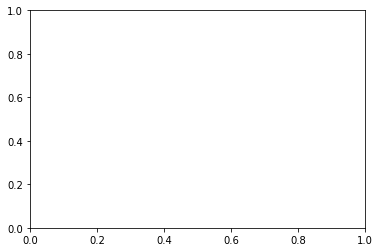

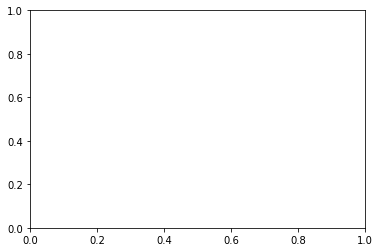

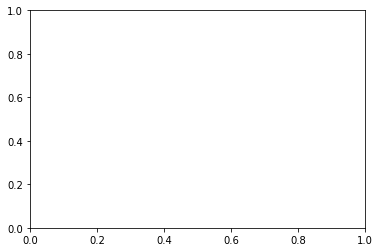

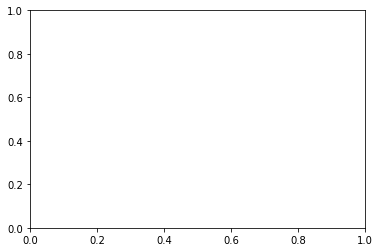

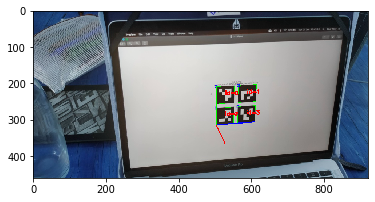

In [50]:
nx = 2
ny = 2
marker_size = 0.025 # 25mm
between_markers = 0.005
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
save_dir = "generated/gridboards"
num_gridboards = 4
gridboards = make_gridboards(nx, ny, marker_size, between_markers, 
                aruco_dict, num_gridboards, save_dir)


length_of_axis = (marker_size + between_markers) * nx - between_markers
images = sorted(glob.glob("gridboards_20/*")[:1])
drawBoardAxes(images, aruco_dict, length_of_axis, gridboards[0], cam_matrix, dist_coeffs)

In [42]:
def drawBoardAxes(images, aruco_dict, length_of_axis, board, cam_matrix, dist_coeffs):    
    for image_path in images:
        print(image_path)
        frame = cv2.imread(image_path)        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)
        
        frame_with_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
#         rvec = rvecs[0]
#         tvec = tvecs[0]
        rvec = np.ones(shape=(3,1), dtype=float)
        tvec = np.ones(shape=(3,1), dtype=float)
        ret, rvec, tvec = aruco.estimatePoseBoard(corners, ids, board, cam_matrix,
                                                        dist_coeffs, rvec, tvec)
                
        frame_with_markers = cv2.drawFrameAxes(frame_with_markers, cam_matrix, 
                                               dist_coeffs, rvec, tvec, 
                                               length_of_axis, thickness=2)
        plt.figure()
        plt.imshow(frame_with_markers, interpolation = "nearest")



# The bare minimum

In [ ]:
def calibrate(original_charuco_dir, factor, vectors=None):
    if not vectors:
        vectors={}
    # First downsize the original photos
    image_dir = f"{original_charuco_dir}_{int(factor*100)}"
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    downsize("calibration_100", image_dir, factor=factor)
    
    # Remove all photos whose markers can't be seen
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*")))
    expected_num_markers = 24
    remove_unclear(aruco_dict, image_paths, expected_num_markers)
    
    # Find the charuco_board in each image
    num_x, num_y = 7, 7
    ratio_marker_border = 6/8
    charuco_board = aruco.CharucoBoard_create(num_x, num_y, 1, ratio_marker_border, aruco_dict)
    allCorners = []
    allIds = []
    decimator = 0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*")))
    imsize = cv2.imread(image_paths[0]).shape[:2]
    for im in image_paths:
        print(f"Processing image {im}")
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        if len(corners) > 0:
            # Sub-pixel detection
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, charuco_board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])
        decimator += 1
    
    (allCorners, allIds, imsize)
    
    # Finally, calibrate the camera using the found corners
    print("Finding camera matrices")
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    (ret, cam_matrix, dist_coeffs, rvecs, tvecs,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors
    ) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=charuco_board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    scaled_errors = [error[0] / imsize[0] for error in perViewErrors]
    vectors[str(factor)] = {}
    vectors[str(factor)]["cam_matrix"] = cam_matrix
    vectors[str(factor)]["dist_coeffs"] = dist_coeffs
    vectors[str(factor)]["ret"] = ret   
    print("Done")
    return vectors
    

In [ ]:
def plot_gridboard_axes(image_path, vectors, factor):
    
    dist_coeffs = vectors[str(factor)]['dist_coeffs']
    cam_matrix = vectors[str(factor)]['cam_matrix']
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
    nx = 2
    ny = 2
    marker_size = 0.025 # 25mm
    between_markers = 0.005 # 5mm
    length_of_axis = (marker_size + between_markers) * nx - between_markers
    offset = 0
    board = aruco.GridBoard_create(nx, ny, marker_size, between_markers, 
                                       aruco_dict, firstMarker=offset)
    
    
    
    print(image_path)
    frame = cv2.imread(image_path)        
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)

    frame_with_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
    rvec = np.ones(shape=(3,1), dtype=float)
    tvec = np.ones(shape=(3,1), dtype=float)
    ret, rvec, tvec = aruco.estimatePoseBoard(corners, ids, board, cam_matrix,
                                                    dist_coeffs, rvec, tvec)

    frame_with_markers = cv2.drawFrameAxes(frame_with_markers, cam_matrix, 
                                           dist_coeffs, rvec, tvec, 
                                           length_of_axis, thickness=3)
    plt.figure()
    plt.imshow(frame_with_markers, interpolation = "nearest")

In [ ]:
VERBOSE = True
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
dict_size = 50
nx = 5
ny = 5
marker_size_cm = 10
marker_size_inches = marker_size_cm * 2.54
padding = marker_size_cm/2
offset = 0

In [ ]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob
%matplotlib nbagg

## Make a Charuco Board
[source](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/sandbox/ludovic/aruco_calibration_rotation.html)

In [ ]:
workdir = "./"
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
num_x, num_y = 7, 7
ratio_marker_border = 6/8
charuco_board = aruco.CharucoBoard_create(num_x, num_y, 1, ratio_marker_border, aruco_dict)
imboard = charuco_board.draw((2000, 2000))
cv2.imwrite(f"{workdir}charuco_{num_x}x{num_y}.tiff", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
if VERBOSE:
    plt.show()

In [ ]:
def downsize(from_dir, to_dir, factor=None):
    image_paths = sorted(glob.glob(os.path.join(from_dir, "*")))
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if factor:
            width = int(img.shape[1] * factor)
            height = int(img.shape[0] * factor)
        else: # 921,460 is 20% of OnePlus 5t
            width = 921
            height = 460
        dim = (width, height)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        path = os.path.join(to_dir, image_path.split(os.sep)[-1])
#         print(f"Saving: {path}")
        if not os.path.exists(to_dir):
            os.makedirs(to_dir)
        cv2.imwrite(os.path.join(to_dir, image_path.split(os.sep)[-1]), resized)
        if VERBOSE and (img.shape[0] != img.shape[0] or resized.shape[1] != resized.shape[1]):
#             fig = plt.figure()
#             ax = fig.add_subplot(1,1,1)
#             plt.imshow(resized)
#             ax.axis('off')  
            print(f"{image_path.split(os.sep)[-1]}: {img.shape} --> {resized.shape}")
#             plt.show()
    print(f"Resized@{factor}, no issues, saved {len(image_paths)} files to {to_dir}")

# image_paths = sorted(glob.glob(datadir + "*"))
# image_paths = sorted(glob.glob("gridboards/*"))
factor = 20
save_path = f"calibration_{factor}"
if not os.path.exists(save_path):
    os.makedirs(save_path)
downsize("calibration_100", save_path, factor=factor/100)

## Downsize the calibration images

In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
num_x, num_y = 7, 7
ratio_marker_border = 6/8
charuco_board = aruco.CharucoBoard_create(num_x, num_y, 1, ratio_marker_border, aruco_dict)

cams = []
dists = []
rets = []

for factor in [20]:
    dir_path = f"calibration_{factor}"
    image_paths = glob.glob(os.path.join(dir_path, "*"))
    print(f"{os.path.join(dir_path, '*')}")
    allCorners, allIds, imsize = read_chessboards(image_paths, charuco_board)
    ret, cam_matrix, dist_coeffs, rvecs, tvecs = calibrate_camera(allCorners, allIds, imsize[:2], charuco_board, images)
    cams.append(cam_matrix)
    dists.append(dist_coeffs)
    rets.append(ret)



## Remove unclear images

In [ ]:
images = sorted(glob.glob("calibration_20/*"))
ret, cam_matrix, dist_coeffs, rvecs, tvecs = calibrate_camera(allCorners, allIds, imsize[:2], charuco_board, images)

In [ ]:
def calibrate_camera(allCorners, allIds, imsize, charuco_board, images=None):
    print("CAMERA CALIBRATION")
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    (ret, cam_matrix, dist_coeffs, rvecs, tvecs,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors
    ) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=charuco_board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    scaled_errors = [error[0] / imsize[0] for error in perViewErrors]
    print(scaled_errors)
    return ret, cam_matrix, dist_coeffs, rvecs, tvecs

In [ ]:
images = sorted(glob.glob("calibration_20/*"))
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
num_x, num_y = 7, 7
ratio_marker_border = 6/8
charuco_board = aruco.CharucoBoard_create(num_x, num_y, 1, ratio_marker_border, aruco_dict)

allCorners, allIds, imsize = read_chessboards(images, charuco_board)

In [ ]:
def remove_unclear(aruco_dict, image_paths, expected_num_markers):
    num_removed = 0
    for i, file_path in enumerate(image_paths):
        frame = cv2.imread(file_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners) != expected_num_markers:
            print(f"{file_path.split(os.sep)[-1]}: len(corners)={len(corners)}", end="")
            frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
            os.remove(file_path)
            print(f"\tremoving {file_path}:")
            num_removed += 1
#             plt.figure()
#             plt.imshow(frame_markers, interpolation = "nearest")
#             plt.show()
    print(f"Removed {num_removed}, {len(image_paths)-num_removed} remaining")
    
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
image_paths = sorted(glob.glob("calibration_20/*"))
expected_num_markers = 24
remove_unclear(aruco_dict, image_paths, expected_num_markers)


In [ ]:
def read_chessboards(images, charuco_board):
    """
    Charuco base pose estimation.
    """
    print(f"Pose Estimation, len(images)={len(images)}")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    imsize = cv2.imread(images[0]).shape
    for im in images:
        print(f"=> Processing image {im}")
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(corners) > 0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, charuco_board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])
        decimator+=1
#         imsize = gray.shape
    return allCorners, allIds, imsize